## First model - labeled CT data

In [1]:
!pip install opencv-python

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import tensorflow

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras import callbacks

from joblib import dump, load

You should consider upgrading via the '/home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
def read_ct_img_bydir(target_dir):
    img=cv2.imdecode(np.fromfile(target_dir,dtype=np.uint8),cv2.IMREAD_GRAYSCALE)
    #img = corp_margin(img)
    img=cv2.resize(img,(200,200))
    
    return img

In [3]:
def get_data():
    '''Loads raw data from image names of each class folder and assigns a label to it.'''
    
    target_dir1='../raw_data/labeled_CT_data/NiCT/'
    target_dir2='../raw_data/labeled_CT_data/pCT/'
    target_dir3='../raw_data/labeled_CT_data/nCT_nd/'

    target_list1=[target_dir1+file for file in os.listdir(target_dir1)]
    target_list2=[target_dir2+file for file in os.listdir(target_dir2)]
    target_list3=[target_dir3+file for file in os.listdir(target_dir3)]

    target_list=target_list1+target_list2+target_list3

    # Assign labels: 0: 'non informative CT'
    #                1: 'positive Covid-19 CT'
    #                2: 'negative Covid-19 CT'
    y_list=to_categorical(np.concatenate(np.array([[0]*len(target_list1),
                                               [1]*len(target_list2),
                                               [2]*len(target_list3)])),3)

    X=np.array([read_ct_img_bydir(file) for file in target_list])[:,:,:,np.newaxis]

    return X, y_list

In [4]:
X,y = get_data()

In [5]:
X.shape

(16689, 200, 200, 1)

In [6]:
y.shape

(16689, 3)

In [7]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
y_test[1]

array([0., 1., 0.], dtype=float32)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Conv2D(64, (3,3), input_shape=(200, 200, 1), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Dense(32, activation="relu"))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation="softmax"))

# The compilation
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = 'accuracy')  # Recommanded optimizer for RNN


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        1

In [12]:
# The fit

es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=3,
                    validation_split=0.3,
                    callbacks=[es],
                    verbose=1)

Epoch 1/3
256/256 [==============================] - 941s 4s/step - loss: 2.0825 - accuracy: 0.6740 - val_loss: 0.0760 - val_accuracy: 0.9780
Epoch 2/3
256/256 [==============================] - 837s 3s/step - loss: 0.0726 - accuracy: 0.9752 - val_loss: 0.0705 - val_accuracy: 0.9775
Epoch 3/3
256/256 [==============================] - 832s 3s/step - loss: 0.0653 - accuracy: 0.9757 - val_loss: 0.0412 - val_accuracy: 0.9846


In [13]:
## The prediction
y_pred = model.predict(X_test)

In [14]:
y_pred.shape

(5007, 3)

In [15]:
y_pred[0]

array([3.0619441e-13, 8.1161656e-13, 1.0000000e+00], dtype=float32)

In [16]:
y_pred_class = np.rint(y_pred)

In [30]:
y_pred_class

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [17]:
pred = model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 112s 716ms/step - loss: 0.0595 - accuracy: 0.9794


In [18]:
pred

[0.05953994020819664, 0.9794288277626038]

In [19]:
# save model
model.save('model_labeled_ct_3epochs')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: model_labeled_ct_3epochs/assets


In [31]:
# Load
from tensorflow.keras.models import load_model
model_loaded = load_model('model_labeled_ct_3epochs')

In [ ]:
# # save model
# model.save('my_model')  # creates a HDF5 file 'my_model.h5'

In [20]:
pred_error = y_pred_class - y_test

In [21]:
x_plot = np.arange(len(y_test))
x_plot

array([   0,    1,    2, ..., 5004, 5005, 5006])

In [27]:
y_pred_class

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [28]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [38]:
np.unique(pred_error)

array([-1.,  0.,  1.], dtype=float32)

In [52]:
predict_errors = list()

for i in range(len(pred_error)):
    predict_errors.append(pred_error[i,0] + pred_error[i,1]+ pred_error[i,2])
predict_errors[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [34]:
y_pred

array([[3.06194414e-13, 8.11616562e-13, 1.00000000e+00],
       [7.71779469e-07, 9.99987483e-01, 1.18502485e-05],
       [4.44400229e-07, 5.45069543e-06, 9.99994159e-01],
       ...,
       [9.99542236e-01, 4.57746821e-04, 7.53449414e-10],
       [2.65752481e-13, 7.88344678e-09, 1.00000000e+00],
       [9.99975324e-01, 6.76020628e-10, 2.46292220e-05]], dtype=float32)

In [35]:
test_pred = model_loaded.predict(X_test)

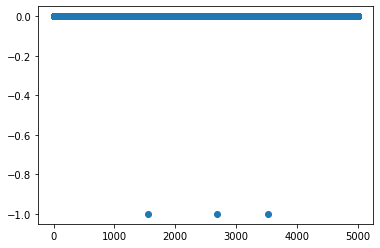

In [78]:
plt.scatter(x_plot, predict_errors);

In [54]:
np.unique(predict_errors)

array([-1.,  0.], dtype=float32)

In [72]:
int_errors = [int(a) for a in predict_errors]

In [76]:
int_errors;

In [96]:
y_df = pd.DataFrame(y)

In [97]:
col1 = y_df[0].sum()
col2 = y_df[1].sum()
col3 = y_df[2].sum()

In [117]:
print('# non-informative labeled CTs: ',col1)
print('# positive labeled CTs: ',col2)
print('# negative labeled CTs: ',col3)

# non-informative labeled CTs:  3113.0
# positive labeled CTs:  4001.0
# negative labeled CTs:  9575.0


In [106]:
cols = [col1, col2,col3]

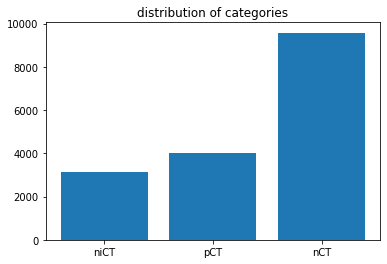

In [113]:
plt.bar(['niCT','pCT','nCT'], cols)
plt.title('distribution of categories');